In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import jax.numpy as jnp
import cloudpickle

from cellrank.kernels import VelocityKernel
from cellrank.estimators import GPCCA
from moscot.problems.time import TemporalProblem
import moscot.plotting as mtp
import seaborn as sns
from cellrank.kernels import RealTimeKernel

# Original Data loading

In [2]:
adata = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/adata_JAX_dataset_3.h5ad")
meta = pd.read_csv('/lustre/groups/ml01/workspace/monge_velo/data/df_cell.csv', index_col=0)
adata.obs['celltype'] = pd.Categorical(
    adata.obs['cell_id'].to_frame().merge(meta, on='cell_id', how='inner')['celltype_update']
)
adata.obs['major_trajectory'] = pd.Categorical(
    adata.obs['cell_id'].to_frame().merge(meta, on='cell_id', how='inner')['major_trajectory']
)
adata.obs['day'] = [float(x[1:]) for x in adata.obs['day']]
adata

AnnData object with n_obs × n_vars = 2643980 × 24552
    obs: 'cell_id', 'keep', 'day', 'embryo_id', 'experimental_batch', 'celltype', 'major_trajectory'
    var: 'gene_id', 'gene_type', 'gene_short_name', 'chr'

# Select timepoints

In [3]:
leave_in = [14.25, 14.333]
adata_time = adata[adata.obs['day'].isin(leave_in)].copy()
adata_time.obs['day'] = adata_time.obs['day'].astype('category')

del adata

In [4]:
sc.pp.pca(adata_time)
sc.pp.neighbors(adata_time)
sc.tl.umap(adata_time)

### Plot Data

/home/icb/jonas.flor/miniconda3/envs/atlas_moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


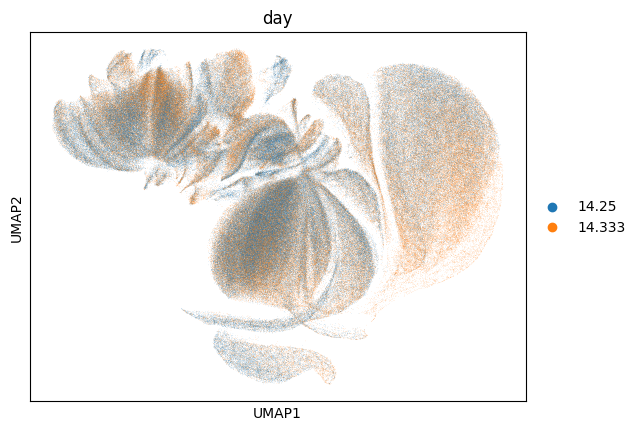

In [5]:
sc.pl.umap(adata_time, color='day')

/home/icb/jonas.flor/miniconda3/envs/atlas_moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


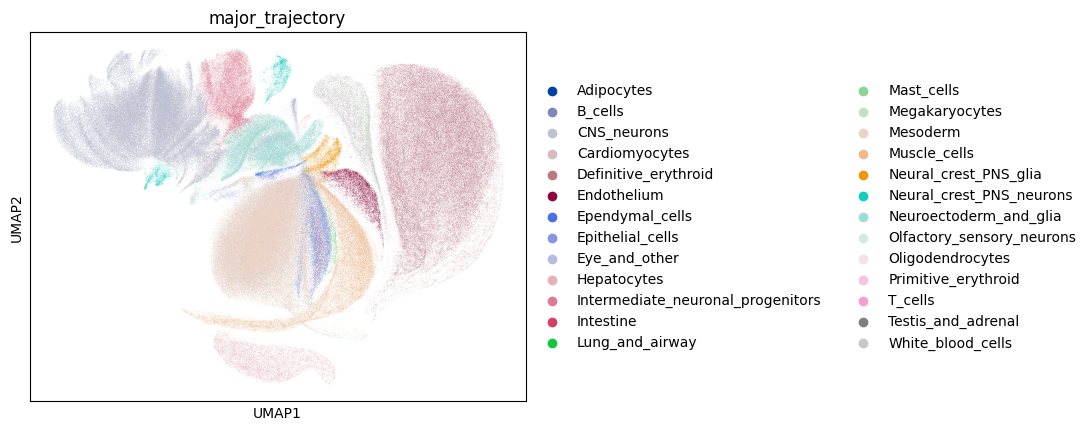

In [6]:
sc.pl.umap(adata_time, color='major_trajectory')

# Subsample

In [7]:
adata_sub = sc.pp.subsample(adata_time, n_obs=10000, copy=True)
sc.pp.pca(adata_sub)
sc.pp.neighbors(adata_sub)
sc.tl.umap(adata_sub)

## Plot data

/home/icb/jonas.flor/miniconda3/envs/atlas_moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


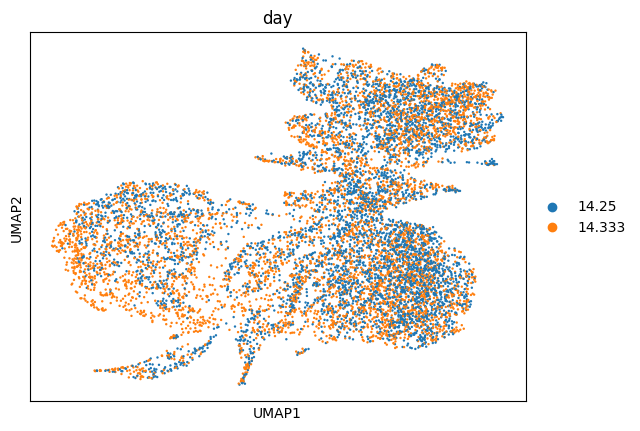

In [8]:
sc.pl.umap(adata_sub, color='day')

/home/icb/jonas.flor/miniconda3/envs/atlas_moscot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


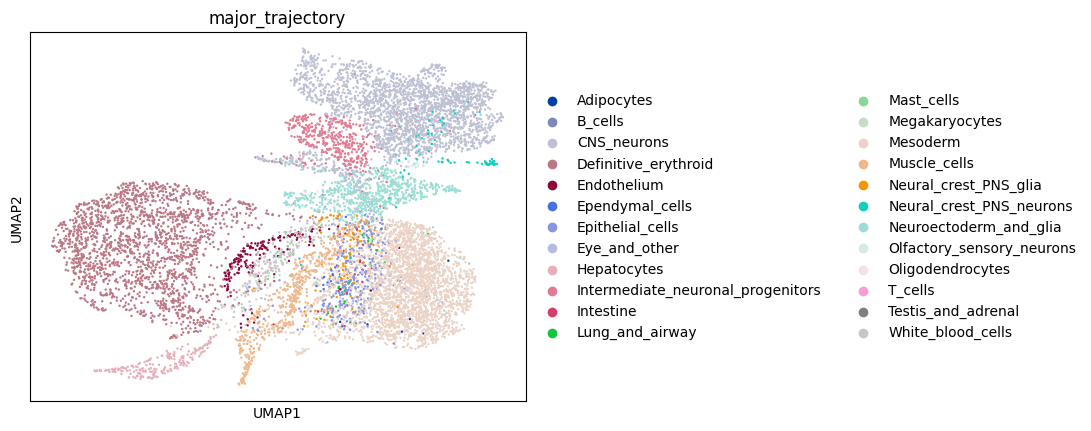

In [9]:
sc.pl.umap(adata_sub, color='major_trajectory')

# Compute temporal problem

In [20]:
tp = TemporalProblem(adata_sub)
tp = tp.prepare("day", joint_attr="X_pca")
tp = tp.solve(epsilon=1e-2, tau_a=0.90, tau_b=0.90)

INFO     Ordering Index(['run_18_PD-01B_S290.TCGTAGCGTTCAGACGAAC-7',                                               
                'run_18_PD-03E_S309.GGTCAGTTTAAGTAAGAGC-7',                                                        
                'run_18_PB-12F_S190.ATATGCCATTGTTCGTCAGA-7',                                                       
                'run_18_PD-01G_S295.CTGACGTTTGTTCTGAATT-7',                                                        
                'run_18_PC-10G_S271.TTCTCATTGTGGCGAACTCG-7',                                                       
                'run_18_PD-12C_S379.CCTCCTGATGTTCGTCAGA-7',                                                        
                'run_18_PD-04F_S318.ACTTACTCATACCGCAGAAT-7',                                                       
                'run_18_PA-12B_S90.TCGAAGGATGTTCCGCTAA-7',                                                         
                'run_18_PA-03G_S23.ACGGAACGTCGTCGCAGCC-7',              

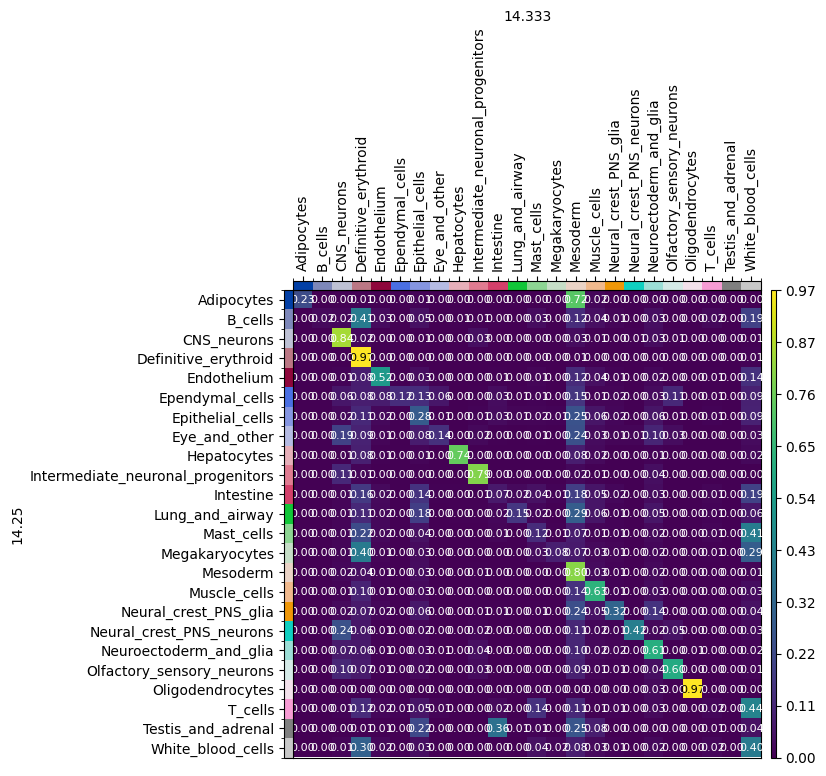

In [21]:
cell_transition = tp.cell_transition(
    source=14.25,
    target=14.333,
    source_groups='major_trajectory',
    target_groups='major_trajectory',
    forward=True,
    key_added="tp_transitions",
)

mtp.cell_transition(
    tp,
    fontsize=8,
    figsize=(5, 5),
    key="tp_transitions",
)

# Velocities

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40time pair/s]


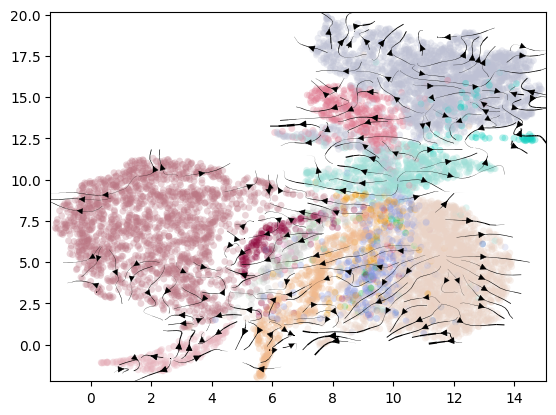

In [22]:
tmk = RealTimeKernel.from_moscot(tp)
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")
try:
    tmk.plot_projection(connectivities=adata_sub.obsp['connectivities'], color='major_trajectory')
except:
    pass

# check subsample

In [ ]:
adata_time.obs.celltype.value_counts()/len(adata_time.obs['celltype'])

In [ ]:
adata_sub.obs.celltype.value_counts()/10000